In [1]:
import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [4]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [5]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

data_path = './data_in/KOR'
op = "./data_out/KOR"

In [6]:
train_path = os.path.join(data_path, "naver_movie", "ratings_train.txt")
test_path = os.path.join(data_path, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(train_path, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

print(f"Total dataset: train - {len(train_data)}")

Total dataset: train - 149995


In [7]:
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [8]:

train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [9]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [10]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(op, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT, 
                        callbacks=[earlystop_callback, cp_callback])

./data_out/KOR\tf2_gpt2_naver_movie -- Folder already exists 

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9772
Epoch 00001: val_accuracy improved from -inf to 0.88627, saving model to ./data_out/KOR\tf2_gpt2_naver_movie\weights.h5
4219/4219 [==============================] - 493s 117ms/step - loss: 0.0594 - accuracy: 0.9772 - val_loss: 0.4741 - val_accuracy: 0.8863
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9799
Epoch 00002: val_accuracy did not improve from 0.88627
4219/4219 [==============================] - 491s 116ms/step - loss: 0.0511 - accuracy: 0.9799 - val_loss: 0.5164 - val_accuracy: 0.8822
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9817
Epoch 00003: val_accuracy did not improve from 0.88627
4219/4219 [==============================] - 491s 116ms/step - loss: 0.0454 - accuracy: 0.9817 - val_loss: 0.5703 - val_accuracy: 0.8801


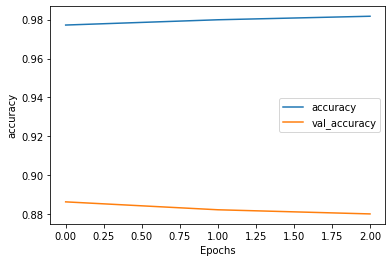

In [29]:
plot_graphs(history, 'accuracy')

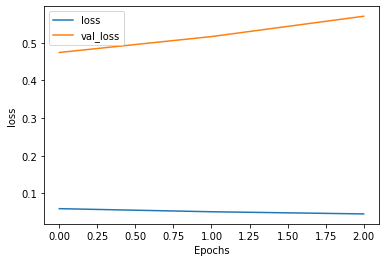

In [30]:
plot_graphs(history, 'loss')

In [31]:
test_data = pd.read_csv(test_path, header=0, delimiter='\t', quoting=3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [25]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document','label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [26]:
print(f"Total dataset: train - {len(train_data)}")
print(f"num sents, labels {len(test_data_sents)}, {len(test_data_labels)}")

Total dataset: train - 149995
num sents, labels 49997, 49997


In [27]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 41s 836ms/step - loss: 0.4172 - accuracy: 0.8845
test loss, test acc:  [0.4172387719154358, 0.8844930529594421]
